In [78]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [79]:
def split_dataset(filepath = "./Boston-filtered.csv", testsize = 1/3):
    data = pd.read_csv(filepath)

    # Randomize the dataset and reset the index, randomstate is used to make the randomization reproducible
    data = data.sample(frac=1).reset_index(drop=True)

    # Split the dataset into features and target
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values

    # Split the dataset into training and test sets
    split_index = int(len(data) * (1 - testsize))

    X_train = X[:split_index]
    y_train = y[:split_index]

    X_test = X[split_index:]
    y_test = y[split_index:]

    return X_train, y_train, X_test, y_test

In [80]:
def gaussian_kernel(xi, xj, sigma):
    sq_dists = np.sum(xi**2, axis=1)[:, None] + np.sum(xj**2, axis=1)[None, :] - 2 * np.dot(xi, xj.T)
    K = np.exp(-sq_dists / (2 * sigma**2))

    return K

In [81]:
def kernel_ridge_regression(X_train, y_train, gamma, K):
    ell = X_train.shape[0]
    I = np.eye(ell)
    alpha_star = np.linalg.inv(K + gamma * ell * I) @ y_train

    return alpha_star

In [91]:
gamma_values = [2**(-40 + i) for i in range(15)]
sigma_values = [2**(7 + i * 0.5) for i in range(13)]

X_train, y_train, X_test, y_test = split_dataset()

def cross_validation(X_train, y_train, gamma_values, sigma_values):
    n = len(y_train)
    fold_size = n // 5

    best_gamma = None
    best_sigma = None
    best_mse = np.inf

    mean_mse_vals = np.zeros((len(gamma_values), len(sigma_values)))

    for gamma_index, gamma in enumerate(gamma_values):
        for sigma_index, sigma in enumerate(sigma_values):
            mse_val_errors = []
            
            for i in range(5):
                val_start = i * fold_size
                val_end = (i + 1) * fold_size if i < 4 else n

                # Validation set
                X_val = X_train[val_start:val_end]
                y_val = y_train[val_start:val_end]

                # Training set
                X_train_fold = np.concatenate([X_train[:val_start], X_train[val_end:]], axis=0)
                y_train_fold = np.concatenate([y_train[:val_start], y_train[val_end:]], axis=0)

                K_train = gaussian_kernel(X_train_fold, X_train_fold, sigma)
                K_val = gaussian_kernel(X_val, X_train_fold, sigma)

                # "Training model"
                alpha_star = kernel_ridge_regression(X_train_fold, y_train_fold, gamma, K_train)

                y_val_pred = K_val @ alpha_star

                mse_val_error = np.mean((y_val - y_val_pred) ** 2)
                mse_val_errors.append(mse_val_error)

            mean_mse_vals[gamma_index, sigma_index] = np.mean(mse_val_errors)

            if np.mean(mse_val_errors) < best_mse:
                best_mse = np.mean(mse_val_errors)
                best_gamma = gamma
                best_sigma = sigma

    return best_gamma, best_sigma, best_mse, mean_mse_vals

best_gamma, best_sigma,best_mse, mean_mse_vals = cross_validation(X_train, y_train, gamma_values, sigma_values)
print(f"Best Gamma: {best_gamma} \nBest Sigma: {best_sigma}  \nBest Validation MSE: {best_mse}")

Best Gamma: 1.4901161193847656e-08 
Best Sigma: 362.03867196751236  
Best Validation MSE: 11.247519736062934


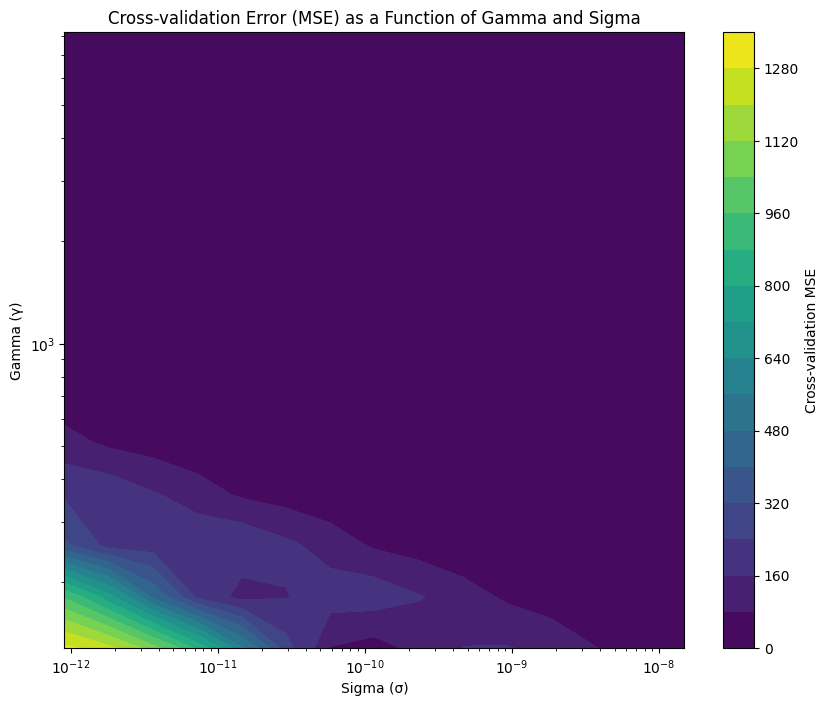

In [92]:
gamma_grid, sigma_grid = np.meshgrid(gamma_values, sigma_values)

# Transpose mean_mse_vals to match the grid's shape (rows for gamma and columns for sigma)
mean_mse_vals_transposed = mean_mse_vals.T  # Now shape (13, 15)

# Plotting the cross-validation errors as a heatmap
plt.figure(figsize=(10, 8))
plt.contourf(gamma_grid, sigma_grid, mean_mse_vals_transposed, 20, cmap='viridis')

# Add a color bar for the cross-validation MSE values
plt.colorbar(label='Cross-validation MSE')

# Labels and title
plt.xlabel('Sigma (σ)')
plt.ylabel('Gamma (γ)')
plt.title('Cross-validation Error (MSE) as a Function of Gamma and Sigma')

# Set logarithmic scales for both axes
plt.xscale('log')
plt.yscale('log')

# Show the plot
plt.show()

In [83]:
K_train_best = gaussian_kernel(X_train, X_train, best_sigma)
K_test_best = gaussian_kernel(X_test, X_train, best_sigma)

    # Step 2: Train the model with the best parameters (on the full training set)
alpha_star_best = kernel_ridge_regression(X_train, y_train, best_gamma, K_train_best)

    # Step 3: Predict for both training and test sets
y_train_pred = K_train_best @ alpha_star_best
y_test_pred = K_test_best @ alpha_star_best

# Step 4: Compute MSE for both training and test sets
train_mse = np.mean((y_train - y_train_pred) ** 2)
test_mse = np.mean((y_test - y_test_pred) ** 2)

print(f"Using best gamma and sigma values")
print(f"Training MSE: {train_mse}")
print(f"Test MSE: {test_mse}")

Using best gamma and sigma values
Training MSE: 7.344273435848167
Test MSE: 18.66496766746761


In [84]:
runs = 20

MSE_train_errors = []
MSE_test_errors = []

for run in range(runs):
    X_train, y_train, X_test, y_test = split_dataset()

    best_gamma, best_sigma, best_mse, _ = cross_validation(X_train, y_train, gamma_values, sigma_values)

    K_train_best = gaussian_kernel(X_train, X_train, best_sigma)
    K_test_best = gaussian_kernel(X_test, X_train, best_sigma)

    alpha_star_best = kernel_ridge_regression(X_train, y_train, best_gamma, K_train_best)

    y_train_pred = K_train_best @ alpha_star_best
    y_test_pred = K_test_best @ alpha_star_best

    train_mse = np.mean((y_train - y_train_pred) ** 2)
    test_mse = np.mean((y_test - y_test_pred) ** 2)

    MSE_train_errors.append(train_mse)
    MSE_test_errors.append(test_mse)

train_errors = np.array(MSE_train_errors)
test_errors = np.array(MSE_test_errors)

mean_train_error = np.mean(train_errors)
std_train_error = np.std(train_errors)
mean_test_error = np.mean(test_errors)
std_test_error = np.std(test_errors)

print(f"Mean Train Error: {mean_train_error:.4e} ± {std_train_error:.4e}")
print(f"Mean Test Error: {mean_test_error:.4e} ± {std_test_error:.4e}")

Mean Train Error: 7.2584e+00 ± 1.4887e+00
Mean Test Error: 1.3035e+01 ± 2.1731e+00
